## Model Architecture

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  #Binary (can be multiclass)

    model = Model(inputs, outputs, name="U-Net")
    return model


## Data Augmentation

Found 80 images belonging to 1 classes.
Found 80 images belonging to 1 classes.
Found 10 images belonging to 1 classes.
Found 10 images belonging to 1 classes.


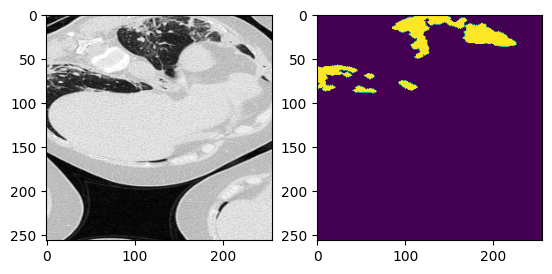

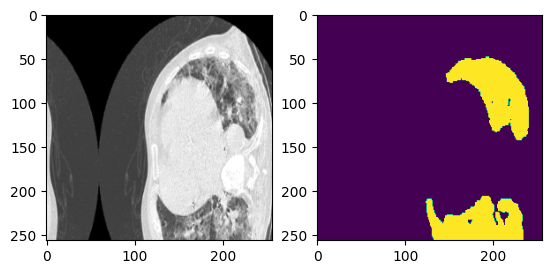

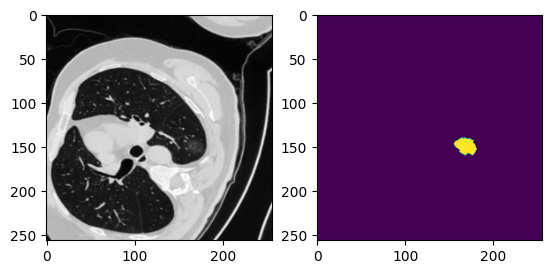

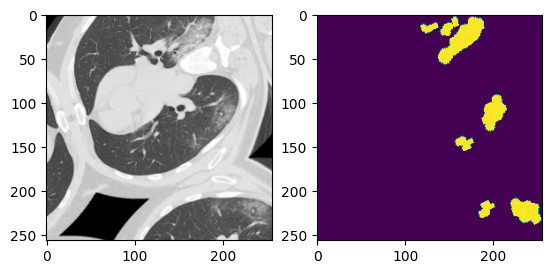

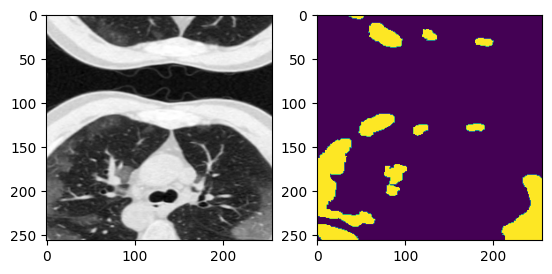

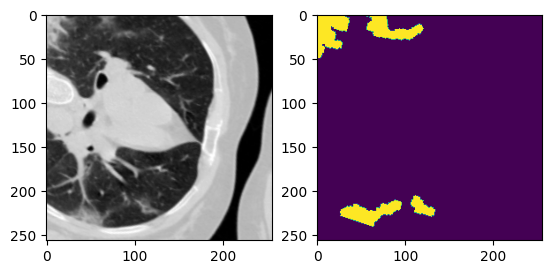

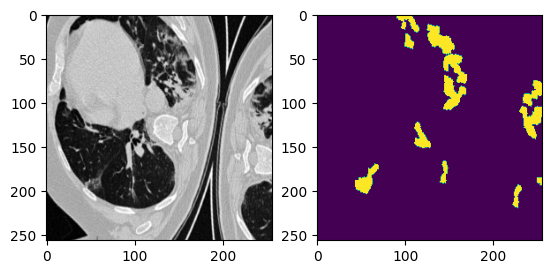

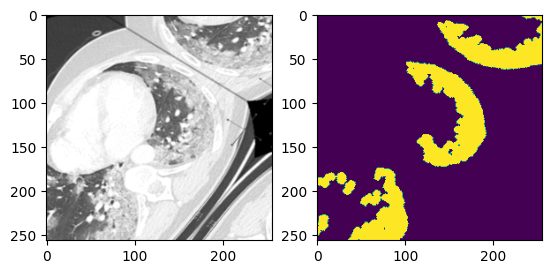

In [17]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

#New generator with rotation and shear where interpolation that comes with rotation and shear are thresholded in masks.
#This gives a binary mask rather than a mask with interpolated values.
seed=42
batch_size= 8
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rescale = 1/255.,
                         rotation_range=90,
                      width_shift_range=0.3,
                      height_shift_range=0.3,
                      shear_range=0.5,
                      zoom_range=0.3,
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')

mask_data_gen_args = dict(rescale = 1/255.,  #Original pixel values are 0 and 255. So rescaling to 0 to 1
                        rotation_range=90,
                      width_shift_range=0.3,
                      height_shift_range=0.3,
                      shear_range=0.5,
                      zoom_range=0.3,
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect',
                      preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again.

#If You need to resize images then add this to the flow_from_directory parameters
#target_size=(150, 150), #Or whatever the size is for your network

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_generator = image_data_generator.flow_from_directory("/content/drive/MyDrive/minyData/train_images",
                                                           seed=seed,
                                                           batch_size=batch_size,
                                                           class_mode=None)  #Very important to set this otherwise it returns multiple numpy arrays
                                                                            #thinking class mode is binary.

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_generator = mask_data_generator.flow_from_directory("/content/drive/MyDrive/minyData/train_masks",
                                                         seed=seed,
                                                         batch_size=batch_size,
                                                         color_mode = 'grayscale',   #Read masks in grayscale
                                                         class_mode=None)


valid_img_generator = image_data_generator.flow_from_directory("/content/drive/MyDrive/minyData/val_images",
                                                               seed=seed,
                                                               batch_size=batch_size,
                                                               class_mode=None) #Default batch size 32, if not specified here
valid_mask_generator = mask_data_generator.flow_from_directory("/content/drive/MyDrive/minyData/val_masks",
                                                               seed=seed,
                                                               batch_size=batch_size,
                                                               color_mode = 'grayscale',   #Read masks in grayscale
                                                               class_mode=None)  #Default batch size 32, if not specified here


train_generator = zip(image_generator, mask_generator)
val_generator = zip(valid_img_generator, valid_mask_generator)



x = image_generator.next()
y = mask_generator.next()
for i in range(0,8):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()


In [18]:
#Define the model. Experiment with various loss functions and accuracy metrics
# pip install focal-loss

#######################################


#Jaccard distance loss mimics IoU.
from keras import backend as K
def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))

    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.

    Ref: https://en.wikipedia.org/wiki/Jaccard_index

    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.sum(K.abs(y_true * y_pred), axis=-1))
    sum_ = K.sum(K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

#Dice metric can be a great metric to track accuracy of semantic segmentation.
def dice_metric(y_pred, y_true):
    intersection = K.sum(K.sum(K.abs(y_true * y_pred), axis=-1))
    union = K.sum(K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1))
    # if y_pred.sum() == 0 and y_pred.sum() == 0:
    #     return 1.0

    return 2*intersection / union

In [19]:
pip install git+https://github.com/artemmavrin/focal-loss.git

  Cloning https://github.com/artemmavrin/focal-loss.git to /tmp/pip-req-build-urb0whdg
  Running command git clone --filter=blob:none --quiet https://github.com/artemmavrin/focal-loss.git /tmp/pip-req-build-urb0whdg
  Resolved https://github.com/artemmavrin/focal-loss.git to commit 7a1810a968051b6acfedf2052123eb76ba3128c4
  Preparing metadata (setup.py) ... done


In [20]:
from focal_loss import BinaryFocalLoss
IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]


input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = build_unet(input_shape)

#STANDARD BINARY CROSS ENTROPY AS LOSS AND ACCURACY AS METRIC
#model.compile(optimizer=Adam(lr = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])

#JACCARD LOSS AND DICE METRIC
#model.compile(optimizer=Adam(lr = 1e-3), loss=jaccard_distance_loss,
 #              metrics=[dice_metric])

#FOCAL LOSS AND DICE METRIC
#Focal loss helps focus more on tough to segment classes.

model.compile(optimizer=Adam(lr = 1e-3), loss=BinaryFocalLoss(gamma=2),
              metrics=['accuracy'])


model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 256, 256, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 256, 256, 64  256        ['conv2d_38[0][0]']              
 ormalization)                  )                                                             

## Training

In [21]:
num_train_imgs = len(os.listdir('/content/drive/MyDrive/minyData/train_images/train/'))

steps_per_epoch = num_train_imgs //batch_size


history = model.fit_generator(train_generator, validation_data=val_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=steps_per_epoch, epochs=80)



model.save('ershad_load_from_disk.hdf5')

<ipython-input-21-1af9154bf8ed>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, validation_data=val_generator,


Epoch 1/80
10/10 [==============================] - 66s 4s/step - loss: 0.1038 - accuracy: 0.8005 - val_loss: 0.9392 - val_accuracy: 0.9123
Epoch 2/80
10/10 [==============================] - 8s 810ms/step - loss: 0.0510 - accuracy: 0.8936 - val_loss: 1.1506 - val_accuracy: 0.9038
Epoch 3/80
10/10 [==============================] - 7s 728ms/step - loss: 0.0651 - accuracy: 0.8798 - val_loss: 0.7672 - val_accuracy: 0.5150
Epoch 4/80
10/10 [==============================] - 10s 1s/step - loss: 0.0530 - accuracy: 0.8834 - val_loss: 1.8532 - val_accuracy: 0.5335
Epoch 5/80
10/10 [==============================] - 8s 824ms/step - loss: 0.0624 - accuracy: 0.8862 - val_loss: 0.9386 - val_accuracy: 0.8980
Epoch 6/80
10/10 [==============================] - 8s 791ms/step - loss: 0.0490 - accuracy: 0.8860 - val_loss: 0.1997 - val_accuracy: 0.7973
Epoch 7/80
10/10 [==============================] - 10s 1s/step - loss: 0.0488 - accuracy: 0.8913 - val_loss: 0.1555 - val_accuracy: 0.5904
Epoch 8/80
1

## Loss and Accuracy Curves

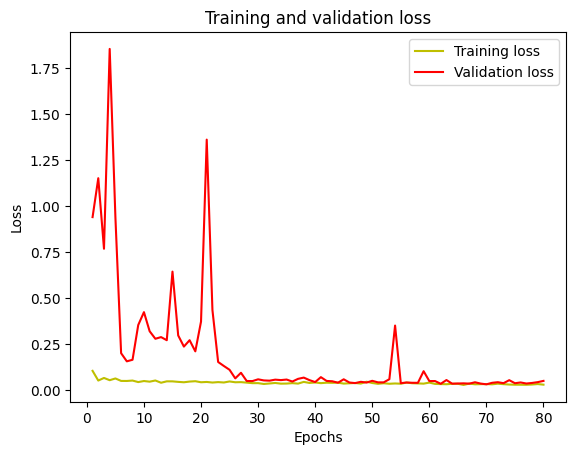

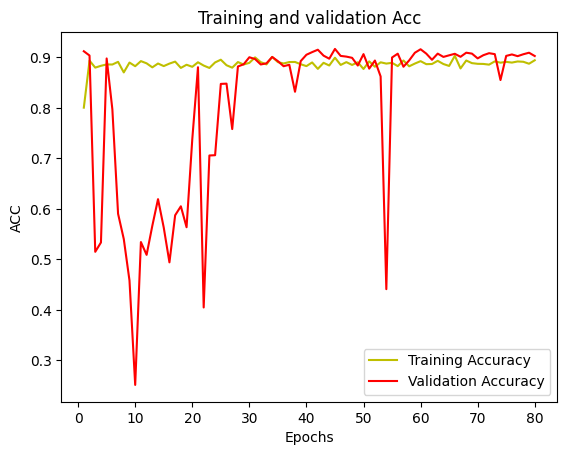

In [22]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
#acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('ACC')
plt.legend()
plt.show()

## Prediction

Found 10 images belonging to 1 classes.
Found 10 images belonging to 1 classes.


1/1 [==============================] - 1s 635ms/step
0.7692164
float32
bool
float32


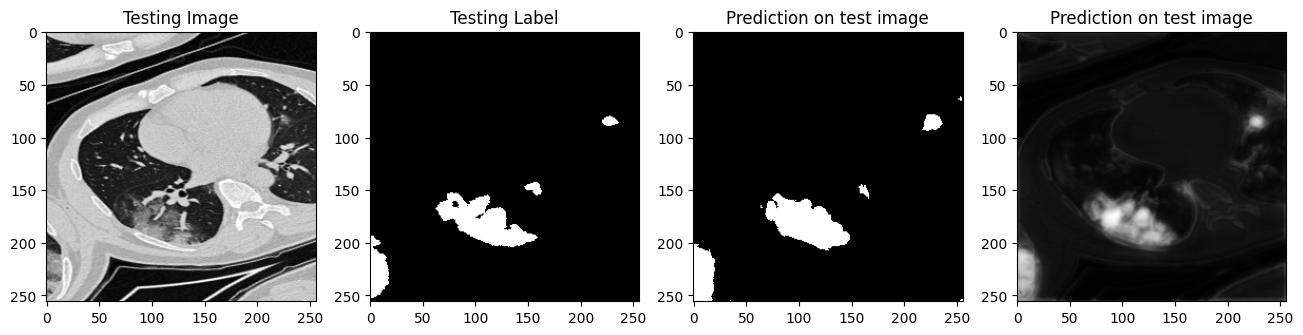

In [30]:
##############################################################
#Test the model on images we held out for testing.
#We can use the generator again for predictions.
#Remember that this is not test time augmentation. This is only using augmentaton
#to load images from the drive, perfomr augmentation and predict.
# TTA means predicting on augmenting images and then combining predictions for better
#accuracy.
import cv2 as cv
import numpy as np
model = tf.keras.models.load_model("ershad_load_from_disk.hdf5", compile=False)

test_img_generator = image_data_generator.flow_from_directory("/content/drive/MyDrive/minyData/test_images",
                                                              seed=seed,
                                                              batch_size=32,
                                                              class_mode=None) #Default batch size 32, if not specified here

test_mask_generator = mask_data_generator.flow_from_directory("/content/drive/MyDrive/minyData/test_masks",
                                                              seed=seed,
                                                              batch_size=32,
                                                              color_mode = 'grayscale',   #Read masks in grayscale
                                                              class_mode=None)  #Default batch size 32, if not specified here

### Testing on a few test images

a = test_img_generator.next()
b = test_mask_generator.next()
# for i in range(0,5):
#     image = a[i]
#     mask = b[i]
#     plt.subplot(1,2,1)
#     plt.imshow(image[:,:,0], cmap='gray')
#     plt.subplot(1,2,2)
#     plt.imshow(mask[:,:,0])
#     plt.show()

import random
test_img_number = 5
#random.randint(0, a.shape[0]-1)
test_img = a[test_img_number]
ground_truth=b[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
pred = model.predict(test_img_input)[0,:,:,0]
biggest = np.amax(pred)
prediction = pred > 0.3* biggest
print(biggest)


print(pred.dtype)
print(prediction.dtype)
print(pred.dtype)

plt.figure(figsize=(16, 8))
plt.subplot(241)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(242)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(243)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')
plt.subplot(244)
plt.title('Prediction on test image')
plt.imshow(pred, cmap='gray')


plt.show()


# #IoU for a single image
# from tensorflow.keras.metrics import MeanIoU
# n_classes = 2
# IOU_keras = MeanIoU(num_classes=n_classes)
# IOU_keras.update_state(ground_truth[:,:,0], prediction)
# print("Mean IoU =", IOU_keras.result().numpy())


# #Calculate IoU and average

# import pandas as pd

# IoU_values = []
# for img in range(0, a.shape[0]):
#     temp_img = a[img]
#     ground_truth=b[img]
#     temp_img_input=np.expand_dims(temp_img, 0)
#     prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.6).astype(np.uint8)

#     IoU = MeanIoU(num_classes=n_classes)
#     IoU.update_state(ground_truth[:,:,0], prediction)
#     IoU = IoU.result().numpy()
#     IoU_values.append(IoU)

#     print(IoU)



# df = pd.DataFrame(IoU_values, columns=["IoU"])
# df = df[df.IoU != 1.0]
# mean_IoU = df.mean().values
# print("Mean IoU is: ", mean_IoU)